## **ПРАКТИЧЕСКОЕ ЗАДАНИЕ**

### **Классификация твитов по тональности**

У нас есть датасет из твитов, про каждый указано, как он эмоционально окрашен: положительно или отрицательно. Задача: предсказывать эмоциональную окраску.

## **Задание 1.**

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

In [1]:
# импортируем библиотеки

import pandas as pd
import numpy as np
import math
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, Flatten
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
!pip install pymorphy2
from pymorphy2 import MorphAnalyzer
from collections import Counter
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)
nltk.download('stopwords')
nltk.download('punkt')
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Conv1D, GRU, LSTM, Dropout, GlobalMaxPool1D, MaxPool1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import matplotlib.pyplot as plt
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 644 kB/s 
     |████████████████████████████████| 8.2 MB 20.2 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=76a1f9bc3c3ed158a2476994af53e1fdc087539b1ec87d8588083a3ea03fa16c
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# вспомогательные функции

# функция очистки текста от ников юзеров
def clean_user(data):
  try:
    find_user = re.findall('@[\w]*', data)
    data = re.sub(find_user[0], ' ', data)
    return data
  except:
    return data  


# функция предсказания сантимента твитов через Логистическую регрессию
def LogRegPred(x_train, y_train, x_test, vector):
  
  bow = vector.fit_transform(x_train)
  clf = LogisticRegression(random_state=42)
  clf.fit(bow, y_train)
  pred = clf.predict(vector.transform(x_test))
  
  return pred, vector, clf


# функция декодирования русского текста
def decode_string(ints):
  strs = chr(ints)
  joined = ''.join(strs)
  return joined

In [3]:
# загрузим данные
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

--2022-08-21 17:50:05--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fnpq3z4bcnoktiv/positive.csv [following]
--2022-08-21 17:50:05--  https://www.dropbox.com/s/raw/fnpq3z4bcnoktiv/positive.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc386b092fbf0a83bd2df70a6806.dl.dropboxusercontent.com/cd/0/inline/BrcEsUCn-eNTxnR8R-GKh913TsvAeZZtRiH1aknxGNdQYhZZNgqiCEh9afo01TH9qo_VwD5F5eZ10HQU9b16-NACazU9wWIqnXdfRfbqQRldCUfPsUl-YmC2WXbXUNd4KrHhgxCu5_p1wETHPpe792HIwFWLvh0Ce8XEAICVQdzdZw/file# [following]
--2022-08-21 17:50:06--  https://uc386b092fbf0a83bd2df70a6806.dl.dropboxusercontent.com/cd/0/inline/BrcEsUCn-eNTxnR8R-GKh913TsvAeZZtRiH1aknxGNdQYhZZNgqiCEh9afo01TH9q

In [4]:
# считаем данные и заполним общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [ ]:
df.tail()

,text,label
111918,Но не каждый хочет что то исправлять:( http://t.co/QNODDQzuZ7,negative
111919,"скучаю так :-( только @taaannyaaa вправляет мозги, но я все равно скучаю",negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :( *обнял*",negative
111922,"Такси везет меня на работу. Раздумываю приплатить, чтобы меня втащили на пятый этаж. Лифта то нет :(",negative


In [ ]:
# разделим на тренировочную и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

In [ ]:
# создадим переменные со стоп-словами и пунктуацией
noise = stopwords.words('russian') + list(punctuation)
stop_words = stopwords.words('russian')

# зададим переменные длины наших датасетов
train_length = x_train.shape[0]
test_length = x_test.shape[0]

In [ ]:
# очистим текст от ников юзеров
x_train = x_train[:train_length].apply(clean_user)

In [ ]:
# получим токены из тренировочного набора
corpus = [token.lower() for tweet in x_train for token in word_tokenize(tweet) if token not in noise]
print(len(corpus))
corpus[:10]

1419631


['rt',
 'а',
 'завтра',
 'загадать',
 'желание',
 '13.12.13',
 '12:13',
 '13:12',
 '13.12.13',
 'rt']

In [ ]:
# составим список частотности токенов
freq_dict = Counter(corpus)
freq_dict_sorted = sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('rt', 28619),
 ('http', 24744),
 ('...', 16741),
 ('это', 14483),
 ('d', 12449),
 ("''", 9311),
 ('я', 9275),
 ('..', 8534),
 ('``', 8514),
 ('сегодня', 6503)]

In [ ]:
len(freq_dict_sorted)

211875

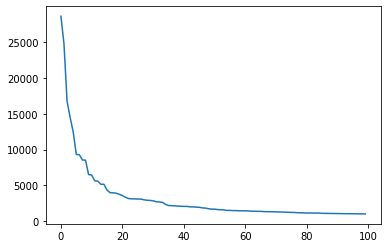

In [ ]:
# график частотности токенов
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

In [ ]:
# разбьем токены с высокой, средней и низкой частотой следующим образом:
# свыше 5 000, от 5 000 до 1 000, ниже 1 000

high_tokens = [word.lower() for word, freq in freq_dict_sorted if (freq > 5000)]
averange_tokens = [word.lower() for word, freq in freq_dict_sorted if (freq < 5000) and (freq > 1000)]
low_tokens = [word.lower() for word, freq in freq_dict_sorted if (freq < 1000)]

print(len(high_tokens))
print(len(averange_tokens))
print(len(low_tokens))

15
86
211774


In [ ]:
# предскажем значения на высокочастотных токенах
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=stop_words, vocabulary=high_tokens)
pred, vector, model = LogRegPred(x_train, y_train, x_test, vec)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.74      0.58      0.65     35402
    positive       0.49      0.66      0.56     21307

    accuracy                           0.61     56709
   macro avg       0.61      0.62      0.60     56709
weighted avg       0.64      0.61      0.62     56709



In [ ]:
# предскажем значения на среднечастотных токенах
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=stop_words, vocabulary=averange_tokens)
pred, vector, model = LogRegPred(x_train, y_train, x_test, vec)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.34      0.65      0.45     14831
    positive       0.82      0.56      0.67     41878

    accuracy                           0.58     56709
   macro avg       0.58      0.60      0.56     56709
weighted avg       0.69      0.58      0.61     56709



In [ ]:
# предскажем значения на низкочастотных токенах
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=stop_words, vocabulary=low_tokens)
pred, vector, model = LogRegPred(x_train, y_train, x_test, vec)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.70      0.74      0.72     26290
    positive       0.76      0.72      0.74     30419

    accuracy                           0.73     56709
   macro avg       0.73      0.73      0.73     56709
weighted avg       0.73      0.73      0.73     56709



### **Вывод:**

**Лучше всего сработали токены, которые реже встречаются в тексте, так как они несут больше информации для классификации.**

## **Задание 2.**

Найти фичи с наибольшей значимостью, и вывести их.

In [ ]:
# предскажем значения без исключения слоп-слов и использования словаря
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize)
pred, vector, model = LogRegPred(x_train, y_train, x_test, vec)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     27866
    positive       1.00      1.00      1.00     28843

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



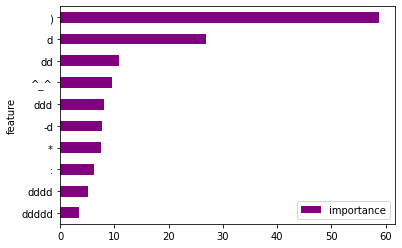

In [ ]:
# выведем наиболее значимые признаки
feature_importance = pd.DataFrame(vector.get_feature_names_out(), columns = ["feature"])
feature_importance["importance"] = model.coef_[0]
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
feature_importance = feature_importance.head(10)

ax = feature_importance.plot.barh(x='feature', y='importance', color='purple')
ax.invert_yaxis()
plt.show()

Посмотрим, как один из супер-значительных токенов справится с классификацией безо всякого машинного обучения:

In [ ]:
# посмотрим на предсказание суперзначимого токена
cool_token = ')'
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      0.85      0.92     32782
    positive       0.83      1.00      0.91     23927

    accuracy                           0.91     56709
   macro avg       0.92      0.93      0.91     56709
weighted avg       0.93      0.91      0.91     56709



### **Вывод:**

**Наиболее значимым токеном оказался знак пунктуации, а именно выгнутая скобочка, смайл.**

## **Задание 3.**

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера 

3) убедиться что для сетки нет переобучения

### **Векторайзеры**

In [ ]:
%%time
# сделаем предсказания через CountVectorizer
count_v = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=stop_words)
pred, vector, model = LogRegPred(x_train, y_train, x_test, count_v)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     27896
    positive       1.00      1.00      1.00     28813

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709

CPU times: user 1min 5s, sys: 5.43 s, total: 1min 11s
Wall time: 1min 8s


In [ ]:
%%time
# сделаем предсказания через TfidfVectorizer
tfidf_v = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=stop_words)
pred, vector, model = LogRegPred(x_train, y_train, x_test, tfidf_v)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     27868
    positive       1.00      1.00      1.00     28841

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709

CPU times: user 48.7 s, sys: 2.88 s, total: 51.6 s
Wall time: 48.3 s


In [ ]:
%%time
# сделаем предсказания через HashingVectorizer на 100 признаках
hash_v_100 = HashingVectorizer(ngram_range=(1, 1), n_features=100, tokenizer=word_tokenize, stop_words=stop_words, token_pattern=None)
pred, vector, model = LogRegPred(x_train, y_train, x_test, hash_v_100)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.96      0.97      0.96     27710
    positive       0.97      0.96      0.96     28999

    accuracy                           0.96     56709
   macro avg       0.96      0.96      0.96     56709
weighted avg       0.96      0.96      0.96     56709

CPU times: user 43.8 s, sys: 131 ms, total: 44 s
Wall time: 44 s


In [ ]:
%%time
# сделаем предсказания через HashingVectorizer на 200 признаках
hash_v_200 = HashingVectorizer(ngram_range=(1, 1), n_features=200, tokenizer=word_tokenize, stop_words=stop_words, token_pattern=None)
pred, vector, model = LogRegPred(x_train, y_train, x_test, hash_v_200)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.98      0.98      0.98     27807
    positive       0.98      0.98      0.98     28902

    accuracy                           0.98     56709
   macro avg       0.98      0.98      0.98     56709
weighted avg       0.98      0.98      0.98     56709

CPU times: user 44 s, sys: 127 ms, total: 44.1 s
Wall time: 44 s


In [ ]:
%%time
# сделаем предсказания через HashingVectorizer на 300 признаках
hash_v_300 = HashingVectorizer(ngram_range=(1, 1), n_features=300, tokenizer=word_tokenize, stop_words=stop_words, token_pattern=None)
pred, vector, model = LogRegPred(x_train, y_train, x_test, hash_v_300)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.99      0.99      0.99     27857
    positive       0.99      0.99      0.99     28852

    accuracy                           0.99     56709
   macro avg       0.99      0.99      0.99     56709
weighted avg       0.99      0.99      0.99     56709

CPU times: user 44.2 s, sys: 108 ms, total: 44.3 s
Wall time: 44.2 s


In [ ]:
%%time
# сделаем предсказания через HashingVectorizer на 400 признаках
hash_v_400 = HashingVectorizer(ngram_range=(1, 1), n_features=400, tokenizer=word_tokenize, stop_words=stop_words, token_pattern=None)
pred, vector, model = LogRegPred(x_train, y_train, x_test, hash_v_400)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.99      0.99      0.99     27915
    positive       0.99      0.99      0.99     28794

    accuracy                           0.99     56709
   macro avg       0.99      0.99      0.99     56709
weighted avg       0.99      0.99      0.99     56709

CPU times: user 45.4 s, sys: 106 ms, total: 45.5 s
Wall time: 45.4 s


### **Вывод:**

**CountVectorizer и TfidfVectorizer сработали по точности одинаково.**

**HashingVectorizer сработал чуть хуже. По количеству признаков, 300 кажется оптимальным количеством, при этом точность составляет 0,99, а экономия времени - 26,9 сек по сравнению с CountVectorizer, и 7,5 сек - с TfidfVectorizer.**

### **Нейронные сети**

In [146]:
# снова поделим данные, чтобы они были без обработки
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

# выделим названия классов
class_names = ['positive', 'negative']

# переведем классы в бинарный вид
y_train.replace('positive', 1, inplace=True)
y_train.replace('negative', 0, inplace=True)
y_test.replace('positive', 1, inplace=True)
y_test.replace('negative', 0, inplace=True)

# переведем данные в тензоры
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# поделим датасеты на батчи
train_data = train_data.batch(32)
test_data = test_data.batch(32)

In [147]:
# посмотрим на один батч
for raw in train_data.take(1):
    print(raw)
    break

(<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'@dancing_cocaine \xd0\xbd\xd0\xb0 \xd1\x81\xd0\xb0\xd0\xbc\xd0\xbe\xd0\xbc \xd0\xb4\xd0\xb5\xd0\xbb\xd0\xb5 \xd0\xb6\xd1\x83\xd1\x82\xd0\xba\xd0\xbe \xd0\xb4\xd0\xbe\xd1\x81\xd1\x82\xd0\xb0\xd0\xb2\xd0\xbb\xd1\x8f\xd0\xb5\xd1\x82 \xd0\xbe\xd1\x82\xd1\x80\xd0\xb8\xd1\x86\xd0\xb0\xd1\x82\xd0\xb5\xd0\xbb\xd1\x8c\xd0\xbd\xd0\xb0\xd1\x8f \xd1\x80\xd0\xb5\xd0\xb0\xd0\xba\xd1\x86\xd0\xb8\xd1\x8f \xd0\xbd\xd0\xb0 \xd0\xbc\xd0\xbd\xd0\xbe\xd0\xb3\xd0\xbe\xd1\x82\xd0\xbe\xd1\x87\xd0\xb8\xd1\x8f :D',
       b'RT @Shumkova0406199: @ann_safina \xd0\xb0\xd1\x85\xd0\xb0\xd0\xb0\xd1\x85\xd0\xb0\xd1\x85 \xd0\xbd\xd1\x83 \xd0\xbe\xd0\xba :) \xd0\x9e\xd0\xbb\xd0\xb5\xd0\xbd\xd1\x8c\xd0\x92\xd0\xb0\xd0\xbd\xd0\xb3\xd0\xb0 \xd1\x8f \xd0\xb2\xd0\xb5\xd1\x80\xd1\x8e \xd1\x82\xd0\xb5\xd0\xb1\xd0\xb5 :3',
       b'@fillip_ina @SimbIblis @cveren1 \xd0\x9e\xd0\xbd\xd0\xb0 \xd0\xbf\xd1\x80\xd0\xb5\xd0\xba\xd1\x80\xd0\xb0\xd1\x81\xd0\xbd\xd0\xb0) \xd0\x93\xd0

In [148]:
# настроим распараллеливание процессов
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [149]:
def custom_standardization(input_data):    
    return input_data

# зададим необходимые переменные
vocab_size = 10000
seq_len = 100
embedding_dim = 200
thld = 0.5

# создадим кастомный слой
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=seq_len)

# создадим словарь
text_data = train_data.map(lambda x, y: x)
vectorize_layer.adapt(text_data)

In [150]:
# создадим нейронную сеть

model = Sequential([
    vectorize_layer,
    Embedding(vocab_size, embedding_dim),
    Conv1D(200, (3)),
    Conv1D(400, (2)),
    MaxPool1D(),
    GRU(300),  
    Dense(200, activation='relu'),
    Dropout(0.25),
    Dense(1)
])

In [151]:
# скомпилируем сеть
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [152]:
# проведем обучение сети
model.fit(train_data, validation_data=test_data, epochs=6)

Epoch 1/6
5317/5317 [==============================] - 72s 13ms/step - loss: 0.6409 - accuracy: 0.5483 - val_loss: 0.4448 - val_accuracy: 0.7187
Epoch 2/6
5317/5317 [==============================] - 64s 12ms/step - loss: 0.4144 - accuracy: 0.7421 - val_loss: 0.3993 - val_accuracy: 0.7352
Epoch 3/6
5317/5317 [==============================] - 66s 12ms/step - loss: 0.3818 - accuracy: 0.7688 - val_loss: 0.3864 - val_accuracy: 0.7509
Epoch 4/6
5317/5317 [==============================] - 65s 12ms/step - loss: 0.3679 - accuracy: 0.7822 - val_loss: 0.3823 - val_accuracy: 0.7614
Epoch 5/6
5317/5317 [==============================] - 65s 12ms/step - loss: 0.3737 - accuracy: 0.7818 - val_loss: 0.3890 - val_accuracy: 0.7528
Epoch 6/6
5317/5317 [==============================] - 64s 12ms/step - loss: 0.3713 - accuracy: 0.7826 - val_loss: 0.3871 - val_accuracy: 0.7547


In [153]:
# посмотрим на одно предложение из тестового набора
row = list(test_data.take(1))
decoded = tf.strings.unicode_decode(row[0][0][4].numpy(), 'utf-8').numpy()
decoded_list = ''.join([decode_string(ex) for ex in decoded])
label = row[0][1][4].numpy()
print(f'{class_names[label]} <--- {decoded_list}')

positive <--- Блин, за своё растование не так обидно ,как за то, что лучший друг растался со своей  девушкой, ребят мне вас жаль(((


In [154]:
# сделаем предсказание для выбранного примера
pred = np.argmax(model.predict([decoded_list]))
print(f'{class_names[pred]} <--- {decoded_list}')

positive <--- Блин, за своё растование не так обидно ,как за то, что лучший друг растался со своей  девушкой, ребят мне вас жаль(((


### **Вывод:**

**На выбранном примере классификация сработала верно.**

In [155]:
# сделаем предсказания для всего тестового набора
nn1_preds = model.predict(test_data)
nn1_preds = (nn1_preds > thld).astype('int32')
print(classification_report(nn1_preds, y_test))

              precision    recall  f1-score   support

           0       0.93      0.69      0.79     37975
           1       0.58      0.90      0.71     18734

    accuracy                           0.75     56709
   macro avg       0.76      0.79      0.75     56709
weighted avg       0.82      0.75      0.76     56709



### **Вывод:**

**Результат работы хуже, чем у векторайзеров.**

In [156]:
# построим еще один вариант нейройнной сети

class myNet(tf.keras.Model):
    def __init__(self):
        super(myNet, self).__init__()
        self.emb = Embedding(vocab_size, embedding_dim, name='embedding')
        self.conv1 = Conv1D(200, (3))
        self.conv2 = Conv1D(200, (3))
        self.gPool = GlobalMaxPool1D()
        self.fc1 = Dense(200, activation='relu')
        self.fc2 = Dense(1)
        self.drp = Dropout(0.5)


    def call(self, x):
        x = vectorize_layer(x)
        x = self.emb(x)
        x1 = self.conv1(x)
        x = self.conv2(x)
        x = self.gPool((x + x1)/2)
        x = self.fc1(x)
        x = self.drp(x)
        x = self.fc2(x)
        return x

In [157]:
# инициализируем модель
mmodel = myNet()

In [158]:
# скопмилируем модель
mmodel.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [159]:
# проведем обучение модели
# были испытания с 6-ю эпохами, но модель переобучалась
mmodel.fit(train_data, validation_data=test_data, epochs=2)

Epoch 1/2
5317/5317 [==============================] - 40s 7ms/step - loss: 0.3625 - accuracy: 0.7873 - val_loss: 0.3368 - val_accuracy: 0.7948
Epoch 2/2
5317/5317 [==============================] - 41s 8ms/step - loss: 0.2955 - accuracy: 0.8380 - val_loss: 0.3533 - val_accuracy: 0.8033


In [160]:
# сделаем предсказания для всего тестового набора
nn2_preds = mmodel.predict(test_data)
nn2_preds = (nn2_preds > thld).astype('int32')
print(classification_report(nn2_preds, y_test))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82     33560
           1       0.71      0.88      0.79     23149

    accuracy                           0.80     56709
   macro avg       0.80      0.82      0.80     56709
weighted avg       0.82      0.80      0.80     56709



### **Вывод:**

**Данная сеть также работает хуже, чем векторайзеры.**

In [161]:
# построим вариант ПОЛНОСВЯЗНОЙ нейройнной сети

class myNet(tf.keras.Model):
    def __init__(self):
        super(myNet, self).__init__()
        self.emb = Embedding(vocab_size, embedding_dim, name='embedding')
        self.flt = Flatten()
        self.fc1 = Dense(400, activation='relu')
        self.fc2 = Dense(200, activation='relu')
        self.fc3 = Dense(1)
        self.drp = Dropout(0.5)


    def call(self, x):
        x = vectorize_layer(x)
        x = self.emb(x)
        x = self.flt(x)
        x = self.fc1(x)
        x = self.drp(x)
        x = self.fc2(x)
        x = self.drp(x)
        x = self.fc3(x)
        return x

In [162]:
# инициализируем модель
fmodel = myNet()

In [163]:
# скопмилируем модель
fmodel.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [164]:
# проведем обучение модели
fmodel.fit(train_data, validation_data=test_data, epochs=3)

Epoch 1/3
5317/5317 [==============================] - 37s 7ms/step - loss: 0.3816 - accuracy: 0.7788 - val_loss: 0.3436 - val_accuracy: 0.7889
Epoch 2/3
5317/5317 [==============================] - 36s 7ms/step - loss: 0.3073 - accuracy: 0.8275 - val_loss: 0.3672 - val_accuracy: 0.7989
Epoch 3/3
5317/5317 [==============================] - 36s 7ms/step - loss: 0.2473 - accuracy: 0.8677 - val_loss: 0.4250 - val_accuracy: 0.7968


In [165]:
# сделаем предсказания для всего тестового набора
nn3_preds = fmodel.predict(test_data)
nn3_preds = (nn3_preds > thld).astype('int32')
print(classification_report(nn3_preds, y_test))

              precision    recall  f1-score   support

           0       0.88      0.75      0.81     32895
           1       0.71      0.86      0.78     23814

    accuracy                           0.80     56709
   macro avg       0.80      0.81      0.80     56709
weighted avg       0.81      0.80      0.80     56709



### **Вывод:**

**Сеть также работает хуже, чем векторайзеры. Для снижения переобучения был использован слой Dropout и снижено количество эпох.**